<a href="https://colab.research.google.com/github/Holzlsauer/kaggle_titanic/blob/main/Titanic_Exploratory_Data_Analysis_and_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Exploratory Data Analysis and Machine Learning from Disaster

Author: **Renato Holzlsauer Mattos Macedo**<br>
Contact: **renato.holzlsauer@gmail.com** - [**GitHub**](https://github.com/Holzlsauer) - [**LinkedIn**](https://www.linkedin.com/in/holzlsauer/)



In [468]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sumary




---

# Setup

In [469]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer

In [470]:
# Set plot style
# plt.style.use('fivethirtyeight')

In [471]:
# List all the files in this directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input/test.csv")

/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input/train.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input/test.csv


---

# Exploratory Data Analysis - EDA

Data dictionary


| Variable | Definition                                 | Key                                            |
| ---------|--------------------------------------------|------------------------------------------------|
| survival |Survival                                    | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [472]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [473]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


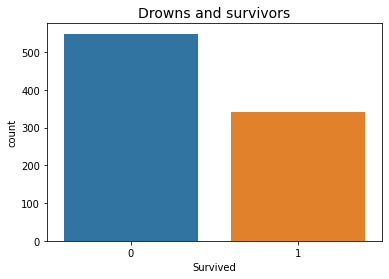


	# of passengers:  891
	# of survivors:   342
	# of drowns:      549


In [474]:
plt.title('Drowns and survivors', fontsize=14)
sns.countplot(x='Survived', data=train)
plt.show()

print(f'\n\t# of passengers:  {len(train)}')
print(f'\t# of survivors:   {train.Survived.sum()}')
print(f'\t# of drowns:      {len(train) - train.Survived.sum()}')

In [475]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In this dataset there's three columns with NaN values based on the number of total passengers. Those columns are **Age**, **Cabin** and **Embarked**.
To be sure, we can see the sum of nan values presents in the dataset.


In [476]:
train_nan = train.isna().sum()
test_nan = test.isna().sum()
index = test_nan.index

pd.DataFrame({ '# of NaN in Train': train_nan, '# of NaN in Test': test_nan }, index=index).T

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
# of NaN in Train,0,0,0,0,177,0,0,0,0,687,2
# of NaN in Test,0,0,0,0,86,0,0,0,1,327,0


Aside of that, in the dataframe info we can see that are some columns with object data type. These types of data aren't apropriated to be feed to the algorithms. The columns **Name**, **Sex**, **Ticket**, **Cabin** and **Embarked** must either be engineered or removed from the dataset.

## Cleaning the dataset

Before we start asking questions and plotting some graphics, we'll deal with the nan values in our dataset.

### Age values

As seen  before, there are 177 passengers without their age information in the dataset. 

One way to fill these nan values is using the mean age value.

(0.0, 35.0)

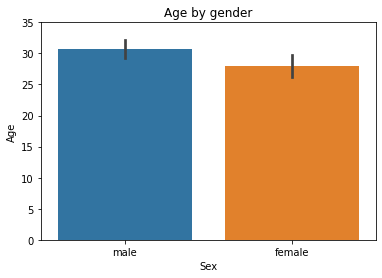

In [477]:
train_age = train[train.Age.isna() == False]

plt.title('Age by gender')
sns.barplot(x='Sex', y='Age', data=train_age);
plt.ylim(0, 35)

In the graphic above we can see that there's a slightly difference between mean value of the ages for each gender. 

It's wise to fill the gaps of gender with its respective mean.

In [478]:
male_age = train_age[train_age.Sex == 'male'].Age.describe()
female_age = train_age[train_age.Sex == 'female'].Age.describe()
index = female_age.index

pd.DataFrame({ 'Male Age': male_age, 'Female Age': female_age }, index=index).T

,count,mean,std,min,25%,50%,75%,max
Male Age,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0
Female Age,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0


In [479]:
def fill_age(df: pd.DataFrame) -> None:
    for gender in 'male', 'female':
        mask = df.Sex == gender
        value = int(df[mask & (df.Age.notnull())].Age.mean())
        df.loc[mask, 'Age'] = df.loc[mask, 'Age'].fillna(value)

for df in train, test:
    fill_age(df)

In [480]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Cabin values

Since there's so many values missing in this column, the way we're going to deal with this is creating a new column named **HasCabin**. This process is done so we can keep the information of a passenger's cabin in some way.

We are going to map this new column as follow:

| Value | Key |
|-|-|
| Has information | 1 |
| NaN | 0 |


In [481]:
def create_has_cabin(df: pd.DataFrame) -> None:
    mask = df.Cabin.notnull()
    df['HasCabin'] = 0
    df.loc[mask, 'HasCabin'] = 1
    df.drop('Cabin', axis=1, inplace=True)

for name, df in zip(('train', 'test'), (train, test)):
    create_has_cabin(df)
    print(f'Total of passenger info with cabin in {name} dataset: {df.HasCabin.sum()}')

Total of passenger info with cabin in train dataset: 204
Total of passenger info with cabin in test dataset: 91


At this point forward we are not going to use the **Cabin** column anymore. This will be dropped later.

### Embarked valeus

Gladly there's only 2 missing values in this column. 

We'll just check which port had the majority of embarks and assume they where from there.

In [482]:
train.groupby(['Embarked'])['PassengerId'].agg(['count'])

,count
Embarked,
C,168
Q,77
S,644


Since **Southampton** had most of the embarks, we're going to use it to fill the nan values.

In [483]:
train.Embarked.fillna('S', inplace=True)

In [484]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  HasCabin     891 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


### Fare values

In the test dataset there one missing value in the **fare** column. As in the age values, we'll fill this gap using the mean value of the **pclass** which this passanger is.

In [485]:
mask = test.Fare.isna()
test.loc[mask, 'Pclass']

152    3
Name: Pclass, dtype: int64

In [486]:
mask = (test.Fare.notnull()) & (test.Pclass == 3)
value = test.loc[mask, 'Fare'].mean()
value

12.459677880184334

In [487]:
test.Fare.fillna(value, inplace=True)

In [488]:
train_nan = train.isna().sum()
test_nan = test.isna().sum()
index = test_nan.index

pd.DataFrame({ '# of NaN in Train': train_nan, '# of NaN in Test': test_nan }, index=index).T

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin
# of NaN in Train,0,0,0,0,0,0,0,0,0,0,0
# of NaN in Test,0,0,0,0,0,0,0,0,0,0,0


## Feature engineering

After cleaning the dataset we can start the process of looking at our features and ask ourselves what kind of information is hidding in there.

At this point we are going to create some new features based on the existing ones and hopefully getting some use for those which willl be dropped later.

### Title

By inspecting the passengers we can see that some of then has some kind of title alongside their name. We will extract this information to a new features named **Title**.

In [489]:
titles = [n.split(',')[1].strip().split('.')[0] for n in train.Name.astype(str)]

pd.DataFrame({'titles': titles}).value_counts()

titles      
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Don               1
the Countess      1
Lady              1
Sir               1
Mme               1
Ms                1
Capt              1
dtype: int64

In [490]:
len(titles)

891

Since some of the titles above have almost none passengers with it, we will put in use just the first four titles: **Mr.**, **Miss.**, **Mrs.** and **Master.**

In [491]:
def get_titles(df: pd.DataFrame) -> None:
    titles = ['Mr.', 'Miss.', 'Mrs.', 'Master.']
    names = [name for name in df.Name.astype(str)]
    df['Title'] = None

    for title in titles:
        mask = [title in name for name in names]
        df.loc[mask, 'Title'] = title

for df in train, test:
    get_titles(df)

train[['Name', 'Title']]

,Name,Title
0,"Braund, Mr. Owen Harris",Mr.
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs.
2,"Heikkinen, Miss. Laina",Miss.
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs.
4,"Allen, Mr. William Henry",Mr.
...,...,...
886,"Montvila, Rev. Juozas",None
887,"Graham, Miss. Margaret Edith",Miss.
888,"Johnston, Miss. Catherine Helen ""Carrie""",Miss.
889,"Behr, Mr. Karl Howell",Mr.


### Sex as numbers

This column is present in text form, as **male** and **female** values. We'll rewrite this column as:

|text|number|
|-|-|
|male|0|
|female|1|

In [492]:
def sex_to_number(df: pd.DataFrame) -> None:
    map = { 'male': 0, 'female': 1 }
    df.Sex = df.Sex.map(map)

for df in train, test:
    sex_to_number(df)

In [493]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,HasCabin,Title
463,464,0,2,"Milling, Mr. Jacob Christian",0,48.0,0,0,234360,13.0000,S,0,Mr.
877,878,0,3,"Petroff, Mr. Nedelio",0,19.0,0,0,349212,7.8958,S,0,Mr.
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",1,19.0,1,0,11967,91.0792,C,1,Mrs.
515,516,0,1,"Walker, Mr. William Anderson",0,47.0,0,0,36967,34.0208,S,1,Mr.
500,501,0,3,"Calic, Mr. Petar",0,17.0,0,0,315086,8.6625,S,0,Mr.


### One Hot Encoding Title and Embarked

In order to use some information present in our dataset, we have to transform it in some numeric form. One way to do is through **one hot encoding**.

In [494]:
def one_hot_encoding(df: pd.DataFrame) -> pd.DataFrame:
    embark = pd.get_dummies(df.Embarked)
    title = pd.get_dummies(df.Title)
    return pd.concat([df, embark, title], axis=1).drop(['Embarked', 'Title'], axis=1)

train = one_hot_encoding(train)
test = one_hot_encoding(test)

In [495]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,HasCabin,C,Q,S,Master.,Miss.,Mr.,Mrs.
231,232,0,3,"Larsson, Mr. Bengt Edvin",0,29.0,0,0,347067,7.775,0,0,0,1,0,0,1,0
752,753,0,3,"Vande Velde, Mr. Johannes Joseph",0,33.0,0,0,345780,9.500,0,0,0,1,0,0,1,0
573,574,1,3,"Kelly, Miss. Mary",1,27.0,0,0,14312,7.750,0,0,1,0,0,1,0,0
418,419,0,2,"Matthews, Mr. William John",0,30.0,0,0,28228,13.000,0,0,0,1,0,0,1,0
505,506,0,1,"Penasco y Castellana, Mr. Victor de Satode",0,18.0,1,0,PC 17758,108.900,1,1,0,0,0,0,1,0


### Family information

We have in our dataset some information about the passenger families. Those information are:

|Column |    Description                                 |
|-------|------------------------------------------------|
|sibsp  |    # of siblings / spouses aboard the Titanic  |
|parch  |	# of parents / children aboard the Titanic 	 |

<br>

From these columns we can create two new columns named **FamilySize**, based on the sum of **sbisp** and **parch**

In [496]:
def get_familysize(df: pd.DataFrame) -> None:
    df['FamilySize'] = df.SibSp + df.Parch

for df in train, test:
    get_familysize(df)

train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,HasCabin,C,Q,S,Master.,Miss.,Mr.,Mrs.,FamilySize
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",1,27.0,1,0,PC 17604,82.1708,0,1,0,0,0,0,0,1,1
584,585,0,3,"Paulner, Mr. Uscher",0,30.0,0,0,3411,8.7125,0,1,0,0,0,0,1,0,0
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,33.0,0,0,110152,86.5000,1,0,0,1,0,0,0,0,0
229,230,0,3,"Lefebre, Miss. Mathilde",1,27.0,3,1,4133,25.4667,0,0,0,1,0,1,0,0,4
95,96,0,3,"Shorney, Mr. Charles Joseph",0,30.0,0,0,374910,8.0500,0,0,0,1,0,0,1,0,0
358,359,1,3,"McGovern, Miss. Mary",1,27.0,0,0,330931,7.8792,0,0,1,0,0,1,0,0,0
406,407,0,3,"Widegren, Mr. Carl/Charles Peter",0,51.0,0,0,347064,7.7500,0,0,0,1,0,0,1,0,0
316,317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",1,24.0,1,0,244367,26.0000,0,0,0,1,0,0,0,1,1
662,663,0,1,"Colley, Mr. Edward Pomeroy",0,47.0,0,0,5727,25.5875,1,0,0,1,0,0,1,0,0
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",0,42.0,1,0,11753,52.5542,1,0,0,1,0,0,1,0,1


In [497]:
train_nan = train.isna().sum()
test_nan = test.isna().sum()
index = test_nan.index

pd.DataFrame({ '# of NaN in Train': train_nan, '# of NaN in Test': test_nan }, index=index).T

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,HasCabin,C,Q,S,Master.,Miss.,Mr.,Mrs.,FamilySize
# of NaN in Train,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
# of NaN in Test,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Features Correlation

At this point with all the cleaning and engineering done we can take a minute before start working in our models and watch more carefully what kind of history our data tell us.

But first, let's get rid of all non numeric data.

In [498]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  HasCabin     891 non-null    int64  
 11  C            891 non-null    uint8  
 12  Q            891 non-null    uint8  
 13  S            891 non-null    uint8  
 14  Master.      891 non-null    uint8  
 15  Miss.        891 non-null    uint8  
 16  Mr.          891 non-null    uint8  
 17  Mrs.         891 non-null    uint8  
 18  FamilySize   891 non-null    int64  
dtypes: float

These features are: **Name** and **Ticket**.
We will drop the **PassengerId** because it doesn't bring no information about the surviability of the passenger.

In [499]:
# PassengerId is needed to submissions
train.drop(['Name', 'Ticket'], axis=1, inplace=True)
test.drop(['Name', 'Ticket'], axis=1, inplace=True)

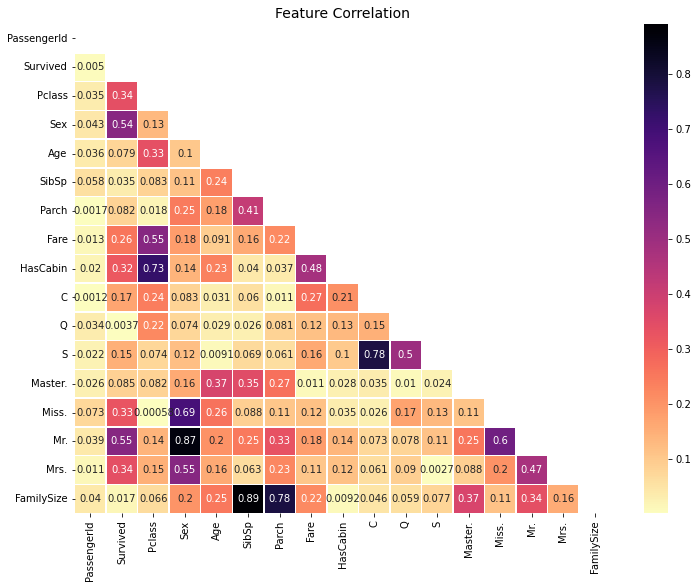

In [500]:
data = train
pallete = sns.color_palette("magma_r", as_cmap=True)

data = abs(train.corr())
tril = np.tril(np.ones(data.shape), k=-1).astype(bool)
data = data.where(tril)

plt.figure(figsize=(12,9))
plt.title('Feature Correlation', fontsize=14)
sns.heatmap(data=data, annot=True, linewidths=.5, cmap=pallete);

From the heatmap above we can see some surpringly strong correlated features, like **HasCabin** and **Pclass**, **Mr.** and **Survived**.

Let's watch the first pair a little closer

### HasCabin and Pclass

In [501]:
train.groupby('Pclass')['HasCabin'].sum()

Pclass
1    176
2     16
3     12
Name: HasCabin, dtype: int64

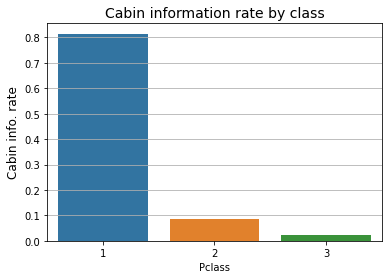

In [502]:
has_cabin_rate = train.groupby('Pclass')
has_cabin_rate = has_cabin_rate['HasCabin'].sum() / has_cabin_rate['Pclass'].value_counts()
has_cabin_rate = has_cabin_rate.droplevel(level=0)

plt.title('Cabin information rate by class', fontsize=14)
sns.barplot(x=has_cabin_rate.index, y=has_cabin_rate)
plt.ylabel('Cabin info. rate', fontsize=12)
plt.grid(axis='y')
plt.show()

Most of the passengers that has some information of their **cabin** was in the first class. Based in the fact tha there's a fairly strong correlation between **pclass** and **survived**. Since its fair to assume that those who was in the first class probably was prioritized for taking the life save boats, we can suspect that those who has **cabin** information have a **higher survivability** rate.

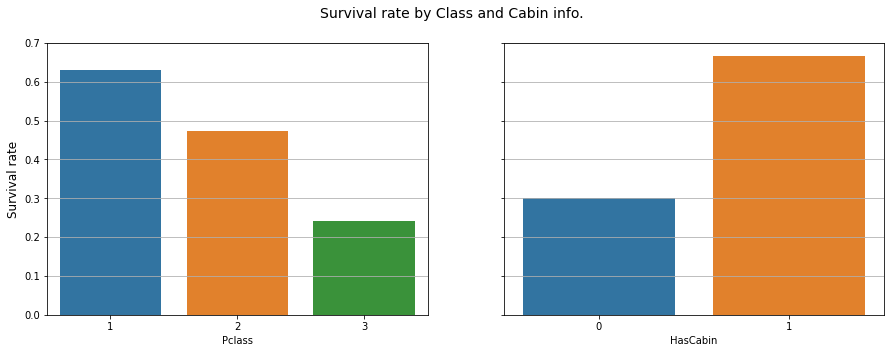

In [503]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
ax[0].set_ylabel('Survival rate', fontsize=12)

plt.suptitle('Survival rate by Class and Cabin info.', fontsize=14)
for k, v in { 'Pclass': 0, 'HasCabin': 1 }.items():
    survival_rate = train.groupby(k)
    survival_rate = survival_rate['Survived'].sum() / survival_rate[k].value_counts()
    survival_rate = survival_rate.droplevel(level=0)

    sns.barplot(x=survival_rate.index, y=survival_rate, ax=ax[v])
    ax[v].grid(True, axis='y')

From the graphics above we can see that the chances of survive of those who has cabin is more than double of those who hasn't. Even so those fron the second class have just aproximately 15% less chance of survive than those in first class, much more compareted with those in third class.

### Mr. Survived

Similarly in the case above, let's check the rate of titles per sex.

In [504]:
titles = ['Master.', 'Miss.', 'Mr.', 'Mrs.']
titles_by_sex = train.groupby('Sex')[titles].sum()
titles_by_sex['Count'] = train.Sex.value_counts()
titles_by_sex.reset_index(inplace=True)
titles_by_sex

,Sex,Master.,Miss.,Mr.,Mrs.,Count
0,0,40.0,0.0,517.0,0.0,577
1,1,0.0,182.0,0.0,125.0,314


In [505]:
for title in titles:
    titles_by_sex[title] = titles_by_sex[title] / titles_by_sex['Count']

titles_by_sex

,Sex,Master.,Miss.,Mr.,Mrs.,Count
0,0,0.069324,0.000000,0.896014,0.000000,577
1,1,0.000000,0.579618,0.000000,0.398089,314


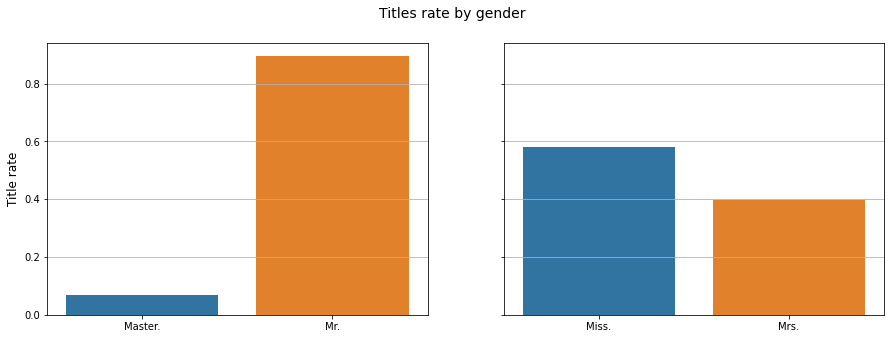

In [506]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
ax[0].set_ylabel('Title rate', fontsize=12)

plt.suptitle('Titles rate by gender', fontsize=14)
for k, v in { 0: ['Master.', 'Mr.'], 1: ['Miss.', 'Mrs.'] }.items():
    mask = titles_by_sex.Sex == k
    data = titles_by_sex.loc[mask, v]

    sns.barplot(data=data, ax=ax[k])
    ax[k].grid(True, axis='y')

Almost 90% of man was called by **Mr.** Since we have a really strong correlation between **Sex** and **Survival**, its fair to assume this is the reason why we have this correlation.

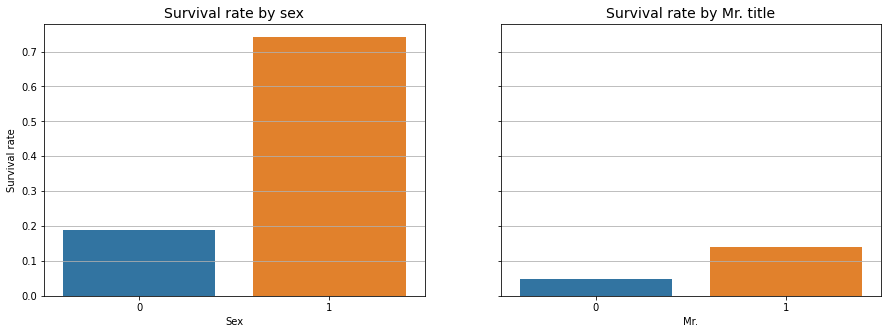

In [507]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)

data = train.groupby('Sex')['Survived'].sum() / train.Sex.value_counts()
sns.barplot(x=data.index, y=data, ax=ax[0])
ax[0].set_title('Survival rate by sex', fontsize=14)
ax[0].set_ylabel('Survival rate')
ax[0].grid(axis='y')

mask = train.Sex == 0
data = train.loc[mask, :]
data = data.groupby('Mr.')['Survived'].sum() / len(data)
sns.barplot(x=data.index, y=data, ax=ax[1])
ax[1].set_title('Survival rate by Mr. title', fontsize=14)
ax[1].set_ylabel('')
ax[1].grid(axis='y')

plt.show()

---

# Training the model

## Data normalization

As the finally last step before training our model, its time to normalize the data. 

ie. Scale all columns with at least one nom zero value to a range between 0 and 1

In [508]:
X = train.drop(['PassengerId', 'Survived'], axis=1)
y = train.Survived

transformer = Normalizer(norm='max').fit(X)
X = transformer.transform(X)

After all the process of cleaning the data, enginnering new features and scalling the variables, its time to begin the trainament of our model!

<br>

Our strategies will be:
- Using RepeatedStratifiedKFold method to split the data
- Adopt the ROC AUC as metric
- Train the model using cross_validate to measure the model

<br>

The model chosen for this first attempt will be the famous **RandomForestClassifier**

In [509]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=0)

In [510]:
def train_model(estimator, data: pd.DataFrame, target: pd.Series, suffix: str=None) -> pd.DataFrame:
    splits = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
    cv = cross_validate(estimator=estimator, X=data, y=target, 
                        scoring='roc_auc', cv=splits, n_jobs=-1, verbose=1)
    
    df = pd.DataFrame(cv)
    if suffix:
        df.columns = [c + suffix for c in df.columns]
    
    return df

rf_cv_results = train_model(random_forest, X, y, suffix='_basemodel')
rf_cv_results.describe()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   46.2s finished


,fit_time_basemodel,score_time_basemodel,test_score_basemodel
count,50.000000,50.000000,50.000000
mean,1.668181,0.120076,0.854187
std,0.037480,0.009483,0.023442
min,1.595736,0.083199,0.788436
25%,1.638372,0.115703,0.838489
50%,1.665931,0.118861,0.859223
75%,1.688998,0.124385,0.869231
max,1.775845,0.139439,0.894519


## Hyperparameter Tuning

As it is our model already perform with high scores. Let's just try to tune some hyperparameters.

In [511]:
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [512]:
params = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 10, 20, 30, 40, 50, 60],
    'max_features': ['auto', 'sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'max_samples': [3, 6, 9, 12, 15],
    'n_estimators': [100, 300, 500, 800, 1000]
}

In [513]:
rscv = RandomizedSearchCV(estimator=random_forest, param_distributions=params, 
                          n_iter=100, scoring='roc_auc', cv=rskf, verbose=1, 
                          n_jobs=-1, random_state=0)

# This line was commented in order to save some time
# rscv.fit(X, y)

In [514]:
# best_params = rscv.best_params_
best_params = {
    'bootstrap': False,
    'criterion': 'gini',
    'max_depth': 20,
    'max_features': 'sqrt',
    'max_samples': 9,
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 500
}

best_params['verbose'] = 1
best_params['n_jobs'] = -1
best_params['random_state'] = 0

In [515]:
rf_tunned = RandomForestClassifier()
rf_tunned.set_params(**best_params)
rf_tunned.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 9,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 1,
 'warm_start': False}

In [516]:
rf_tunned_cv_results = train_model(rf_tunned, X, y, suffix='_tunnedmodel')
rf_tunned_cv_results.describe()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.9s finished


,fit_time_tunnedmodel,score_time_tunnedmodel,test_score_tunnedmodel
count,50.000000,50.000000,50.000000
mean,1.456900,0.205556,0.862439
std,0.073105,0.001372,0.025491
min,1.332410,0.203912,0.779278
25%,1.413684,0.204807,0.849983
50%,1.447106,0.205216,0.863508
75%,1.481578,0.205812,0.880854
max,1.600543,0.210014,0.901252


In [517]:
df_cv_results = pd.concat([rf_tunned_cv_results.describe(), rf_cv_results.describe()], axis=1)
df_cv_results[[c for c in df_cv_results.columns if 'test_score' in c]].T

,count,mean,std,min,25%,50%,75%,max
test_score_tunnedmodel,50.0,0.862439,0.025491,0.779278,0.849983,0.863508,0.880854,0.901252
test_score_basemodel,50.0,0.854187,0.023442,0.788436,0.838489,0.859223,0.869231,0.894519


## Submission

In [529]:
def create_submission(estimator, train: pd.DataFrame, test: pd.DataFrame, output_name: str) -> None:
    X_test = test.drop('PassengerId', axis=1)
    X_train = train.drop(['PassengerId', 'Survived'], axis=1)
    y_train = train['Survived']
    
    for X in X_train, X_test:
        transformer = Normalizer(norm='max').fit(X)
        X = transformer.transform(X)
    
    estimator.fit(X_train, y_train)
    prediction = estimator.predict(X_test)
    
    df = pd.DataFrame(prediction, columns=['Survived'])
    df = pd.concat([test.PassengerId, df], axis=1)
    df.to_csv(f'{output_name}.csv', index=False)

In [534]:
path = '/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/output/'
create_submission(rf_tunned, train, test, f'{path}second_submission')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


In [535]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/kaggle/titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/titanic-starter-notebook.ipynb
/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/ Titanic - Exploratory Data Analysis and Machine Learning from Disaster.ipynb
/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/outputsecond_submission.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input/train.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/input/test.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/output/second_submission.csv
